## Projected urban growth (2018-2035)

While taking a much needed break from thesis writing, I was toying around with map visualizations in Python.
After all, plotting maps of the land has got to be similar to making maps of the sky, right?
All in all, plotting geospatial data turned out to be a rather easy, and I spent most time looking for a decent data to plot and on a formidable task of [choosing which map projection to use](https://xkcd.com/977/).

Search on publicly available datasets eventually landed me on UN [World Urbanization Prospects](https://esa.un.org/unpd/wup/) page, with their 2018 report containing estimates for populations of urban areas with >300,000 population, as well as their projected yearly populations all the way until 2035! So what can you you tell from a population dynamics of cities over decades? 

It seems that globally, you'd expect two effects coming into play simultaneously: the overall *population change* of a given country, as well as the *urbanization pace* within it. Just from those two, we can predict some trends in the dataset already, though I'm clearly cheating in pretending that I haven't looked at the data already:

- Large population increases in countries like India and China will unavoidably lead to increase in city populations. On the other hand, population decline of Japan will definitely show up in the population dynamics visualized.
- While much of the Western world already heavily urbanized, many countries still maintain large rural populations. According to the UN report, Africa and Asia are home to nearly 90% of the world's rural population. The UN report [assumes](https://esa.un.org/unpd/wup/General/FAQs.aspx) that the urban/rural ratio development will follow the overall world trend, and we expect to see a large fractional change in urban population in [relatively rural](https://en.wikipedia.org/wiki/Urbanization#/media/File:2015_World_Urbanization_Map.png) countries.

So let's see where the cities will grow most/least! Two Python plotting frameworks are to be explored:

1. Riding on top of a heavily-customizable behemoth of scientific plotting, [matplotlib](https://matplotlib.org/), the map-making [basemap](https://matplotlib.org/basemap/) package.
2. [D3.js](https://d3js.org/)-based [plot.ly](https://plot.ly/) framework is a modern web-driven visualization tool, with a whole bunch of high-level plotting routine. Its lower-level customization is limited due to my near-illiteracy in javascript, so we're going to use Python implementation of plotly.

### Obtaining the data

The Excel file can be downloaded [here](https://esa.un.org/unpd/wup/Download/Files/WUP2018-F22-Cities_Over_300K_Annual.xls). I used LibreOffice to convert it to a .csv file that's included in this repo.

*Data source: United Nations, Department of Economic and Social Affairs, Population Division (2018). World Urbanization Prospects: The 2018 Revision, Online Edition.*

In [55]:
import pandas as pd

fname="data/WUP2018-F22-Cities_Over_300K_Annual.csv"
df = pd.read_csv(fname, thousands=" ", skiprows=16, index_col=4)

# adding some basics on the UN-projected city growth, 2018-2035
df["growthabs"] = df["2035"] - df["2018"]
df["growthperc"] = df["growthabs"] / df["2018"] * 100 

With the data loaded, let's think on what we want to show to begin with. Two quantities are of interest: the *absolute* population change and the *fractional* one. The cities that show the most total population change are not necessarily the same cities that show the biggest percentage growth! Let's quickly check this before going further:

In [66]:
from IPython.display import display, HTML
import pandas as pd

# top fractional change
top_ten_abs = df.growthabs.sort_values()[-10:]
# prettyfy the output
top_ten_abs = (top_five_abs/1000).map('{:+.2f} million'.format)
top_ten_abs.reset_index(name='Top ten population change (2035)')

,Urban Agglomeration,Top five population change (2035)
0,Dar es Salaam,+7.33 million
1,Mumbai (Bombay),+7.36 million
2,Lahore,+7.38 million
3,Karachi,+7.73 million
4,Al-Qahirah (Cairo),+8.43 million
5,Shanghai,+8.76 million
6,Lagos,+10.96 million
7,Dhaka,+11.66 million
8,Kinshasa,+13.51 million
9,Delhi,+14.83 million


No surprises here - the largest population influx is in big Asian and African megacities.

In [69]:
from IPython.display import display, HTML
import pandas as pd

# Bottom and top fractional change:
top_ten_frac = df.growthperc.sort_values()[-10:]
# Prettyfy:
top_ten_frac = top_ten_frac.map('{:+.2f}%'.format)
top_ten_frac.reset_index(name='Top ten fractional change')

,Urban Agglomeration,Top ten fractional change
0,Lokoja,+126.80%
1,Tete,+128.92%
2,Uige,+129.71%
3,Bunia,+129.92%
4,Kampala,+134.56%
5,Gwagwalada,+138.33%
6,Songea,+139.48%
7,Zinder,+142.60%
8,Kabinda,+145.98%
9,Bujumbura,+151.72%


Evidently, the top 5 fractional growth is projected to occur rapidly-growing African cities. In fact, 94 out of 100 fastest-growing cities are in Africa! This means that urbanization alone can not explain the population increase in urban areas, and is coupled with the overall population growth. The reason behind the latter is that Africa's population is young and is expected to [double by 2050](https://www.theguardian.com/global-development-professionals-network/2016/jan/11/population-growth-in-africa-grasping-the-scale-of-the-challenge), driven by access to better healthcare (meaning higher life expectancy and lower infant mortality rates), while the [total fertility rates](https://en.wikipedia.org/wiki/Total_fertility_rate) remain high.

In any case, let's get back to plotting! For each city, a marking on the map is to be made. We'll use the absolute population change as a size of it, and a fractional change will be shown in color.

### Plotting with matplotlib

The high level of customization possible in `matplotlib` allows to do whatever we want with the colors of the markers. We'll make a custom colormap for the job, with red representing population decline, green for the growth, and yellow for the zero change midpoint.

In [2]:
from matplotlib.colors import Normalize
import numpy as np

class MidpointNormalize(Normalize):
    """ 
    Used to force a zero level in a colormap.
    Neat for forcing reds to negative urban growth.

    Taken from Joe Kington's answer on StackOverflow:
    https://stackoverflow.com/a/20146989/4118756
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y)) 

Now for the actual plotting, the `basemap` will handle all the map projections, while the scatter plot, colorings, legend and colorbar are handed over to `matplotlib`. Had to tinker a bit with the color ranges and sizes of the points (power-scaling makes better visual contrast and an absolute offset allows small changes to still be seen).

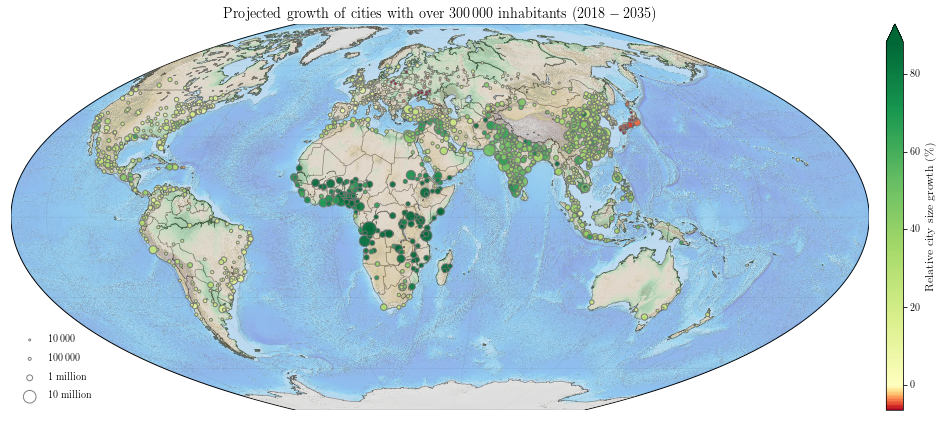

In [3]:
% matplotlib inline
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap

plt.rc('text', usetex=True)

# scale markers by absolute growth
growth_to_msize = lambda p: np.abs(p)**0.7 + 10
m_size = df['growthabs'].apply(growth_to_msize)

# color markers by relative growth
m_col = df['growthperc']
vmin, vmax = np.percentile(m_col, 1), np.percentile(m_col, 95) 
normalize = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

# Basemap takes plt.gcf() as a figure but doesn't pass kwargs to figures
plt.figure(figsize=(16, 8)) 
# we don't want xkcd to infer our personality type, hence the
# choice of the McBryde-Thomas Flat Polar Quartic projection
bmap = Basemap(resolution='l', projection='mbtfpq', lon_0=45, lat_0=0)
bmap.drawmapboundary(fill_color='#c6dbef')
bmap.fillcontinents(color='#f2e0c9', lake_color='#c6dbef',
                    zorder=0.8, alpha=0.5)
bmap.etopo(alpha=0.3, zorder=0.9)
bmap.drawcoastlines(linewidth=0.6, zorder=0.9, color='#525252')
bmap.drawcountries(linewidth=0.6, zorder=0.9, color='#525252')
x, y = bmap(df['Longitude'].values, df['Latitude'].values)
bmap.scatter(x, y, c=m_col,
            s=m_size, marker='.', alpha=0.9, edgecolor='#737373',
            cmap=plt.cm.RdYlGn, norm=normalize, zorder=1)
cbar = bmap.colorbar(size='2%', extend='max')
cbar.set_label(r'$\mathrm{Relative~city~size~growth~(\%)}$',
               fontsize='large')
plt.gca().set_title(r'$\mathrm{Projected~growth~of~cities~with~over'
              '~300\,000~inhabitants~(2018-2035)}$', fontsize='x-large')

bmap.drawparallels(np.arange(-90.,120.,30.), zorder=0.7,
                   color='#969696', linewidth=0.3)
bmap.drawmeridians(np.arange(0.,360.,60.), zorder=0.7,
                   color='#969696', linewidth=0.3)

# display size scale of the scatter points
for dp, lab in zip([10, 100, 1000, 10000],
        [r'$10\,000$', r'$100\,000$',
         r'$1~\mathrm{million}$', r'$10~\mathrm{million}$']):
    plt.scatter([], [], facecolor='none', edgecolor='#737373', alpha=0.9,
                s=growth_to_msize(dp), marker='.', label=lab)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left')

# basemap issue:
# https://stackoverflow.com/questions/15003353
cbar.set_alpha(1)
cbar.draw_all()

plt.show()

And there we have it, as pretty as I could get it to be! The only downsides is that it's noninteractive and takes a bit of time to generate. So let's see how web-based approach works!

### Plotting with plotly

Since we're embedding figures into a Jupyter notebook, we need some extra tinkering:

In [22]:
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

Everything related to the individual data points is defined below:

In [19]:
growth_to_msize = lambda p: np.abs(p)**0.5 + 3
m_col = df['growthperc']
cmin, cmax = np.percentile(m_col, 1), np.percentile(m_col, 95)

df['growth_abs_str'] = df.growthabs.apply(lambda n: f'{n*1000:+,d}')
df['growth_perc_str'] = df.growthperc.apply(lambda p: f'{p:+.1f}%')
# using hiddent atttributes is bad and I should feed bad
df['growth_str'] = df[['growth_abs_str', 'growth_perc_str']].apply(
            lambda x: f'{x._name}: {x[0]} ({x[1]})', axis=1)

urban_growth = [dict(
        name = df.index.values,
        lon = df['Longitude'],
        lat = df['Latitude'],
        marker = dict(
            color = df['growthperc'], # color by fractional increase
            colorscale = 'Portland', # palette name
            colorbar = {'ticksuffix': '%'},
            reversescale = True, # invert the colorbar mapping
            showscale = True, # show colorbar?
            cmin = cmin,
            cmax = cmax,
            sizemode = 'area', # could play with power scale instead
            size = growth_to_msize(df['growthabs'])
            ),
        type = 'scattergeo',
        showlegend = False,
        text = df['growth_str'],
        hoverinfo = 'text'
    )]

... and all the settings for a more global layout are described here:

In [20]:
layout = dict(
    title = 'Projected growth of cities with over'
             ' 300,000 inhabitants (2018-2035)'
             '<br>Source: <a href="https://esa.un.org/unpd/wup/">'
             ' UN World Urbanization Prospects 2018</a>',
    showlegend = True,
    geo = dict(
        scope = 'world',
        projection = dict(type='orthographic'),
        showland = True,
        showcoastlines = True,
        resolution = '110', # the only other available option is too slow!
        showcountries = True,
        countrycolor = '#525252',
        showocean = True,
        oceancolor = '#c6dbef',
        showlakes = True,
        lakecolor = '#c6dbef',
        showrivers = True,
        rivercolor = '#c6dbef',
        landcolor = '#f2e0c9',
        subunitwidth = 1,
        countrywidth = 1,
        #subunitcolor = "rgb(255, 255, 255)", # que es?
    ))

With these two, we just have to call one command and we have an interactive spinning globe with informative tooltips showing the exact values for each urban area.

If you're viewing this on GitHub, the `plot.ly` figure probably isn't rendered, so here's a [link to the figure](plot.ly/~vlas-sokolov/14) instead.

In [21]:
iplot(dict(data=urban_growth, layout=layout))

Pretty neat, but I would've loved to customize the plotly settings more. For once, I am not satisfied with the "arbitrary" colorbar - ideally I would like to stretch to "most yellow" color to zero percent growth, but I am not quite sure how to get a custom color mapping like this in `plotly`. Additionally, the map resolution is too coarse if we zoom into a smaller region, and the only other option allowed for it makes the whole figure rather sluggish. 

Importing GeoJSON data into [Google Maps API](https://developers.google.com/maps/documentation/javascript/datalayer) seems to be a faster way of doing things, but while the examples on the web look impressing, I have no clue how to proceed with something like a colorbar - and there's no offline option either.